Steps to complete before executing this notebook:

(1) Install needed python libraries: ccdproc, photutils.  To do this, go to a terminal window (Mac) or command line (Windows) and type "conda install ccdproc" (for example).  Repeat with other.

(2) Download data 

(3) Put data in a directory (also known as a Folder) named "raw" and note its full path (also known as address).  For example, my data are saved here: /Users/csalyk/Dropbox/DATA/VASSAR/2018/Apr18/raw on a Mac.  For Windows machines, the format is slightly different, something like "C:\\Users\\csalyk\\Data\\raw" with double slashes.
(4) In your parent directory (mine is called Apr18) create a new directory called "overscan_sub" and another new directory called "reduced".

(5) Have this webpage open so you can look at your images: 
https://js9.si.edu/

In [2]:
import sys

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import ccdproc as ccdp
from ccdproc import trim_image
from ccdproc import subtract_overscan

import os

from skimage.registration import phase_cross_correlation
import pickle as pickle

from astropy.io import fits
from astropy import units as u
from astropy.nddata import CCDData
from astropy.stats import sigma_clipped_stats
from astropy.modeling.models import Gaussian2D

from astropy.visualization import make_lupton_rgb, SqrtStretch, ZScaleInterval

import scipy.ndimage.interpolation as interp

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

Define your directories.  Make sure these are already set up on your machine, and that your flat images are processed and in the reduced directory

In [3]:
raw_dir='/Users/mariahjones/Desktop/Research/projects/ASTR240/MCI/raw/'
overscan_dir='/Users/mariahjones/Desktop/Research/projects/ASTR240/MCI/overscan_sub/'
reduced_dir='/Users/mariahjones/Desktop/Research/projects/ASTR240/MCI/reduced/'

flat_dir=reduced_dir

Since we already overscan-subtracted all of our images in the flat_processing notebook, we won't have to do it here

## Create a master dark

First inspect exposure times to decide on strategy.

Option 1: Average all dark frames with same exposure time as science frames.

Option 2: Subtract bias from all dark frames, then scale by exposure time for each science frame.

I don't think we took dark images with the same exposure times as our images, so strategy 2 will need to be used for at least some images.  But you could also play around with strategy 1 for some images.  For v images, we did take 60s darks, so I'm going to use that.

In [3]:
#Inspect all images to look at exposure times of science and dark frames
#all_images = ccdp.ImageFileCollection(overscan_dir,glob_include='*b.fit')  
#all_images = ccdp.ImageFileCollection(overscan_dir,glob_include='*r.fit')  
all_images = ccdp.ImageFileCollection(overscan_dir,glob_include='*v.fit')  
#all_images = ccdp.ImageFileCollection(overscan_dir,glob_include='*d.fit') 

all_images.summary['file','imagetyp','exptime'].show_in_notebook()

Now run this code to collect and make master darks.  (You can make more if you need to for other exposure times)

In [4]:
#ID all dark files with 30s, 60s, 75s, 15s exposures
dark_ifc=ccdp.ImageFileCollection(overscan_dir,glob_include='*d.fit')
dark_files_75s = dark_ifc.files_filtered(exptime=75.0,include_path=True)  #extract 75s darks
dark_files_60s = dark_ifc.files_filtered(exptime=60.0,include_path=True)  #extract 60s darks
dark_files_30s = dark_ifc.files_filtered(exptime=30.0,include_path=True)  #extract 30s darks
dark_files_15s = dark_ifc.files_filtered(exptime=15.0,include_path=True)  #extract 15s darks

combined_dark_75 = ccdp.combine(dark_files_75s, unit='adu',
                             output_file=overscan_dir+'master_dark_75s.fit',overwrite_output=True)  

combined_dark_60 = ccdp.combine(dark_files_60s, unit='adu',
                             output_file=overscan_dir+'master_dark_60s.fit',overwrite_output=True)  

combined_dark_30 = ccdp.combine(dark_files_30s, unit='adu',
                             output_file=overscan_dir+'master_dark_30s.fit',overwrite_output=True)

combined_dark_15 = ccdp.combine(dark_files_15s, unit='adu',
                             output_file=overscan_dir+'master_dark_15s.fit',overwrite_output=True)

## Inspect master flats

In our case, our flats are already constructed.  Let's inspect the flat to make sure it's reasonable.  Look carefully to see dust "donuts".

*You will need to look at all flats by replacing the file name*.

(2048, 2048)


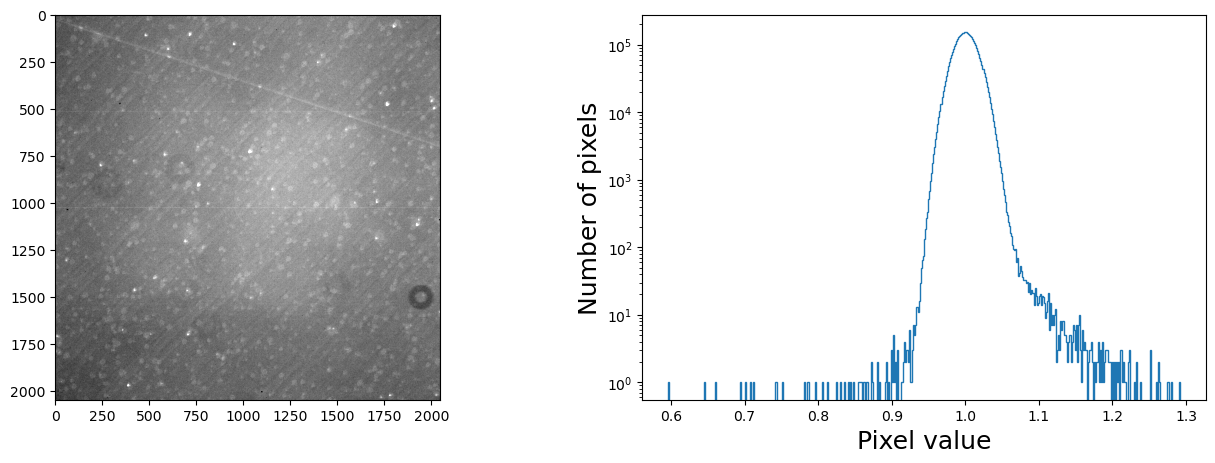

In [5]:
flat_file=flat_dir+'rFLAT.fit'  #Look at all flats by replacing this name with bFLAT, rFLAT etc.
flat_hdul = fits.open(flat_file)   #Read in flat image
flat_img = flat_hdul[0].data

fig=plt.figure(figsize=(16,5))
#Plot image
ax1=fig.add_subplot(121)
ax1.imshow(flat_img, cmap='gray',vmin=np.median(flat_img)*0.95, vmax=np.median(flat_img)*1.05)

ax2=fig.add_subplot(122)
ax2.hist(flat_img.flatten(),histtype='step',bins=500)
ax2.set_yscale('log')
ax2.set_xlabel('Pixel value',fontsize=18)
ax2.set_ylabel('Number of pixels',fontsize=18)

#Print out shape of image to make sure it's been overscan-subtracted
print(np.shape(flat_img))

## "Reduce" data files (perform dark subtraction, division by flat).  Bias was already subtracted via the overscan region

Let's do one image to test the procedure

In [10]:
#First, select all V-filter images with 60s exposure times.
science_ifc=ccdp.ImageFileCollection(overscan_dir,glob_include='*v.fit')
science_files = science_ifc.files_filtered(include_path=True,exptime=60.0)
print('Testing reduction on....', science_files[0])
science_ccd1=CCDData.read(science_files[0], unit="adu")  #Choose a science file to test

master_dark_ccd=CCDData.read(overscan_dir+'master_dark_60s.fit', unit="adu")

flat_ccd=CCDData.read(flat_dir+'vFLAT.fit', unit="adu")

#Subtract the dark from the science image
reduced_ccd1 = ccdp.subtract_dark(science_ccd1, master_dark_ccd,
                              exposure_time='EXPTIME', #Name of exposure time in header
                              exposure_unit=u.second)
#Note: I'm not using scale=True this time, because the science and darks have 60s exposure

#Divide the dark-subtracted science image by the flat
reduced_ccd1 = ccdp.flat_correct(reduced_ccd1, flat_ccd)

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu2 in the FITS file.


Testing reduction on.... /Users/mariahjones/Desktop/Research/projects/ASTR240/MCI/overscan_sub/24mar25-001v.fit
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu2 in the FITS file. [astropy.nddata.ccddata]


Now output the resulting image, to make sure it's sensible, and to check that the reduced image is improved over the raw image.

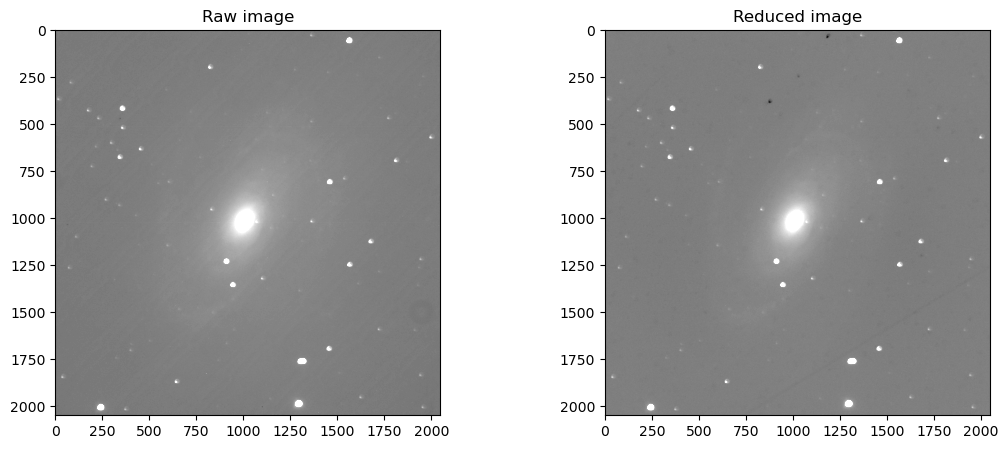

In [12]:
fig=plt.figure(figsize=(13,5))
#Plot image
ax1=fig.add_subplot(121)
ax1.set_title('Raw image')
ax1.imshow(science_ccd1.data, cmap='gray',vmin=np.median(science_ccd1.data)*0.5, 
           vmax=np.median(science_ccd1.data)*1.5)
plt.savefig('raw_image_v')

ax2=fig.add_subplot(122)
ax2.set_title('Reduced image')
ax2.imshow(reduced_ccd1.data, cmap='gray',vmin=np.median(reduced_ccd1.data)*0.5, 
           vmax=np.median(reduced_ccd1.data)*1.5)
plt.savefig('reduced_image_v')

Now we'll turn this into a loop over all images.  Run this to define the function that will run the reduction loop

In [8]:
def data_reduction_loop(science_files, master_dark_file, master_flat_file, overscan_dir, reduced_dir, flat_dir):

    master_dark_ccd=CCDData.read(overscan_dir+master_dark_file, unit="adu")
    flat_ccd=CCDData.read(flat_dir+master_flat_file, unit="adu")
    
    for i, myfile in enumerate(science_files):
        science_ccd=CCDData.read(overscan_dir+myfile, unit="adu") 
 
    #Subtract the dark from the science image
        reduced_ccd = ccdp.subtract_dark(science_ccd, master_dark_ccd,
                                      exposure_time='EXPTIME', #Name of exposure time in header
                                      exposure_unit=u.second)

    #Divide the dark-subtracted science image by the flat
        reduced_ccd = ccdp.flat_correct(reduced_ccd, flat_ccd)

    #Write file out
        outfile=reduced_dir+myfile
        print("Writing reduced image data to:",outfile)
        reduced_ccd.write(outfile,overwrite=True)

Now run the loop, once for each color of image.  

I have written the code for the v images.  You will need to add appropriate code for your other colors.

In [9]:
#Define flat. Define list of science images from overscan. Run loop.
#I noticed that 003v.fit is blurred, so I'm going to remove that and only work with 001 and 002
master_flat_file='vFLAT.fit'
master_dark_file='master_dark_60s.fit'
science_ifc=ccdp.ImageFileCollection(overscan_dir,filenames=['24mar25-001v.fit','24mar25-002v.fit','24mar25-003v.fit',
                                                             '24mar25-005r.fit','24mar25-006r.fit','24mar25-007r.fit',
                                                             '24mar25-002i.fit','24mar25-003i.fit','24mar25-004i.fit',
                                                             '24mar25-005b.fit','24mar25-006b.fit','24mar25-007b.fit'])
science_files = science_ifc.files_filtered()
data_reduction_loop(science_files, master_dark_file, master_flat_file, overscan_dir, reduced_dir, flat_dir)


#You will need to add additional code here to process your other color images

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu2 in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu2 in the FITS file. [astropy.nddata.ccddata]
Writing reduced image data to: /Users/mariahjones/Desktop/Research/projects/ASTR240/MCI/reduced/24mar25-001v.fit
Writing reduced image data to: /Users/mariahjones/Desktop/Research/projects/ASTR240/MCI/reduced/24mar25-002v.fit
Writing reduced image data to: /Users/mariahjones/Desktop/Research/projects/ASTR240/MCI/reduced/24mar25-003v.fit
Writing reduced image data to: /Users/mariahjones/Desktop/Research/projects/ASTR240/MCI/reduced/24mar25-005r.fit
Writing reduced image data to: /Users/mariahjones/Desktop/Research/projects/ASTR240/MCI/reduced/24mar25-006r.fit
Writing reduced image data to: /Users/mariahjones/Desktop/Research/projects/ASTR240/MCI/reduced/24mar25-007r.fit
Writing reduced image data to: /Users/mariahjones/Desktop/Research/projects/ASTR240/M

## Compute image shifts, align images, and add together for each filter

Define a simple function to compute image shifts. This code uses the "register_translation" function.

In [10]:
def compute_image_shifts(science_files, reduced_dir, output_file, ref_file=None,plot=True,ref_pos=None):
    if(ref_file is None): 
        ref_file=science_files[0]     ## choose an image to define as zero shift:
    science_ccd1=CCDData.read(reduced_dir+ref_file, unit="adu") 
    zero_shift_data = science_ccd1.data
    imshifts = {} # dictionary to hold the x and y shift pairs for each image

    for i, myfile in enumerate(science_files):
        science_ccd=CCDData.read(reduced_dir+myfile, unit="adu") 
        print("Shifting", myfile)
        data=science_ccd.data
    ## phase_cross_correlation is a function that calculates shifts by comparing 2-D arrays
        result, error, diffphase = phase_cross_correlation(zero_shift_data, data, upsample_factor=5)

        imshifts[myfile] = result
        if(ref_pos is not None):
            fig=plt.figure()
            ax1=fig.add_subplot(111)
            ax1.imshow(data,cmap='Greys',vmin=np.median(data)*0.5, 
               vmax=np.median(data)*1.5)
            print(result)
            ax1.plot(ref_pos[0]-result[1],ref_pos[1]-result[0], 'r+',markersize=20)
            plt.show()
    pickle.dump( imshifts, open(reduced_dir+output_file, "wb" ))  #Write image shifts to file

Now define list of images and name of image shift output file. Then run loop.  **Warning!!** This code takes several minutes and may use a lot of processor power.  Don't run this code unless you're sure you want to.

I have only done this for the v images so far.  You will want to add your other colors to the "filenames" list and run the alignment on all images.

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Shifting 24mar25-001v.fit
[0. 0.]


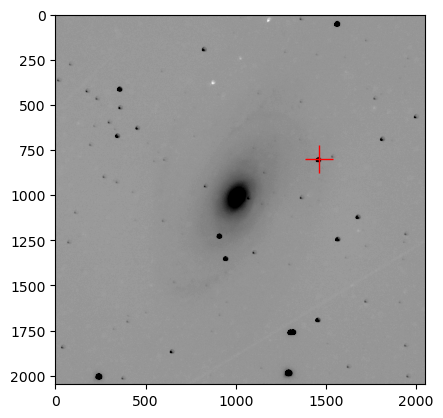

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Shifting 24mar25-002v.fit
[0.6 2.6]


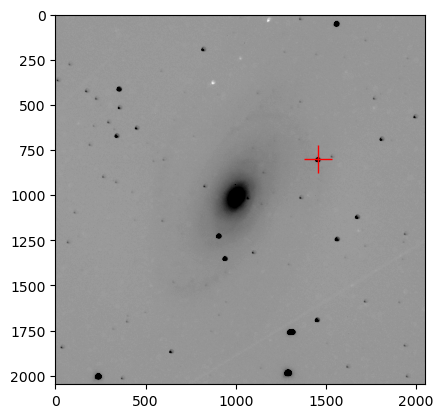

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Shifting 24mar25-003v.fit
[0. 0.]


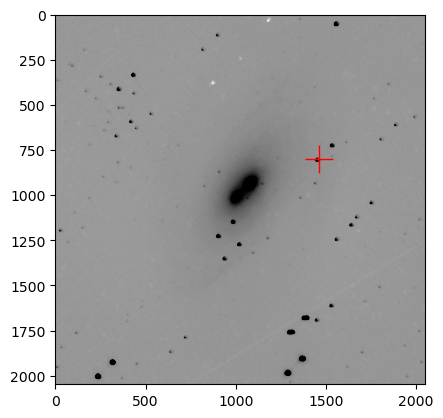

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Shifting 24mar25-005r.fit
[ -0.8 -11. ]


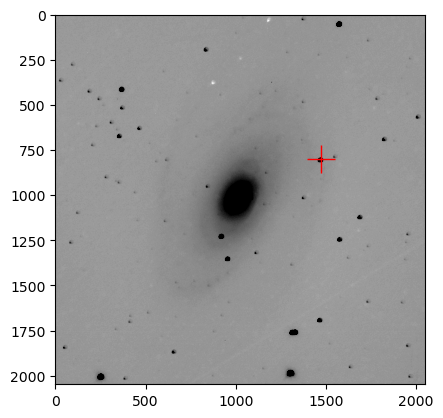

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Shifting 24mar25-006r.fit
[-1.2 -9.8]


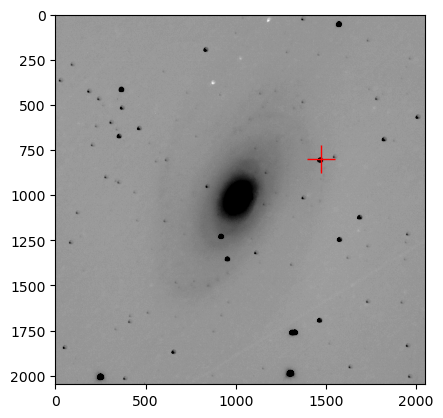

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Shifting 24mar25-007r.fit
[0. 0.]


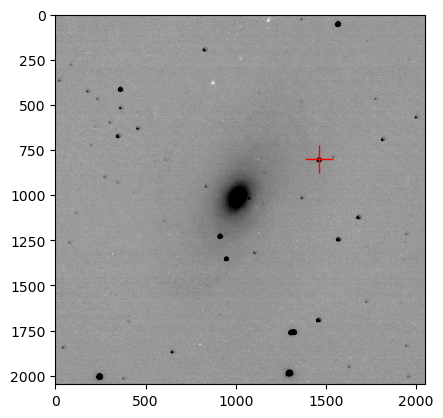

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Shifting 24mar25-002i.fit
[ 79.8 -71. ]


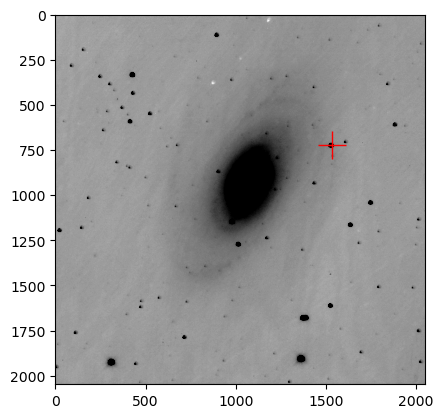

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Shifting 24mar25-003i.fit
[ 80.2 -68.4]


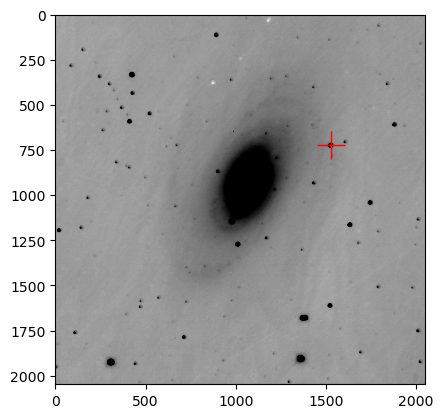

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Shifting 24mar25-004i.fit
[ 82. -66.]


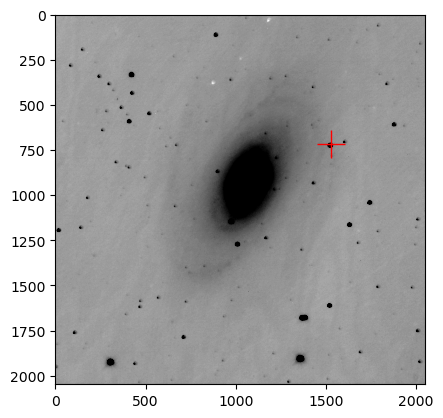

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Shifting 24mar25-005b.fit
[0. 0.]


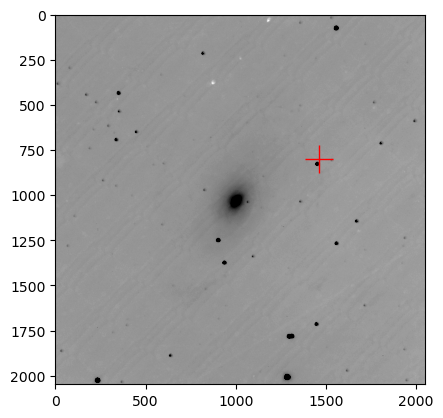

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Shifting 24mar25-006b.fit
[-12.   0.]


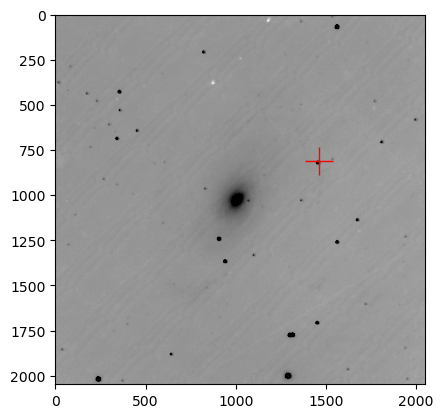

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Shifting 24mar25-007b.fit
[-10.6   2.2]


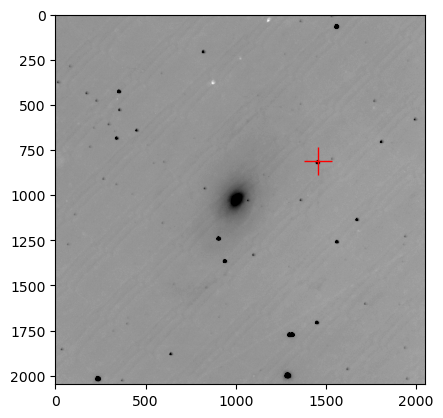

In [11]:
#Read in all files you want to have aligned
#You will need to add your other colors to this image list
science_ifc=ccdp.ImageFileCollection(reduced_dir,filenames=['24mar25-001v.fit','24mar25-002v.fit','24mar25-003v.fit',
                                                             '24mar25-005r.fit','24mar25-006r.fit','24mar25-007r.fit',
                                                             '24mar25-002i.fit','24mar25-003i.fit','24mar25-004i.fit',
                                                             '24mar25-005b.fit','24mar25-006b.fit','24mar25-007b.fit'])
science_files = science_ifc.files_filtered()
output_file='image_shifts.p'

compute_image_shifts(science_files, reduced_dir, output_file, ref_pos=np.array([1460,800])) #Comment this out if you don't want to run it accidentally.

Let's understand what the image shifts file holds.  When you are done, you should have shifts for ALL of your color images.

In [12]:
imshifts = pickle.load(open(reduced_dir+'image_shifts.p', "rb" ))
imshifts

{'24mar25-001v.fit': array([0., 0.]),
 '24mar25-002v.fit': array([0.6, 2.6]),
 '24mar25-003v.fit': array([0., 0.]),
 '24mar25-005r.fit': array([ -0.8, -11. ]),
 '24mar25-006r.fit': array([-1.2, -9.8]),
 '24mar25-007r.fit': array([0., 0.]),
 '24mar25-002i.fit': array([ 79.8, -71. ]),
 '24mar25-003i.fit': array([ 80.2, -68.4]),
 '24mar25-004i.fit': array([ 82., -66.]),
 '24mar25-005b.fit': array([0., 0.]),
 '24mar25-006b.fit': array([-12.,   0.]),
 '24mar25-007b.fit': array([-10.6,   2.2])}

To check shifts, I'll show all images with positions of shifted stars.  First, I'll write a program to do this.

In [13]:
def show_image_shifts(science_files, reduced_dir, shift_file='image_shifts.p',ref_pos=None):
    ## choose an image to define as zero shift:
    imshifts = pickle.load(open(reduced_dir+shift_file, "rb" )) # dictionary to hold the x and y shift pairs for each image

    for i, myfile in enumerate(science_files):
        science_ccd=CCDData.read(reduced_dir+myfile, unit="adu") 
        print("Showing", myfile)

        data=science_ccd.data
    ## register_translation is a function that calculates shifts by comparing 2-D arrays
        result=imshifts[myfile]
        if(ref_pos is not None):
            fig=plt.figure()
            ax1=fig.add_subplot(111)
            ax1.imshow(data,cmap='Greys',vmin=np.median(data)*0.5, 
               vmax=np.median(data)*1.5)
            print(result)
            ax1.plot(ref_pos[0]-result[1],ref_pos[1]-result[0], 'r+',markersize=20)
            plt.show()

Now I'll run my 'show_image_shifts' routine to make sure the shifts look good.

I've only done this for v images so far.  You'll want to add your other color images to the filenames list

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Showing 24mar25-001v.fit
[0. 0.]


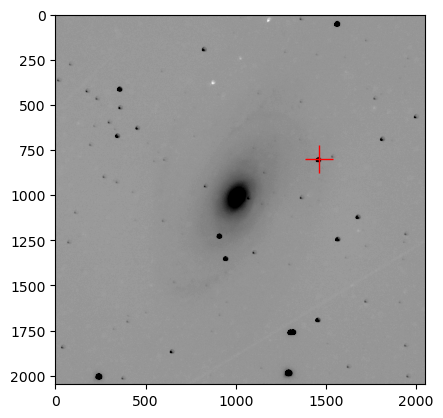

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Showing 24mar25-002v.fit
[0.6 2.6]


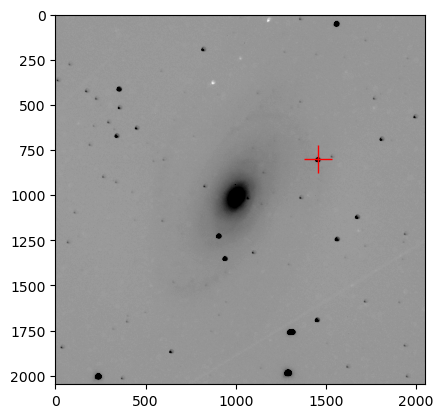

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Showing 24mar25-003v.fit
[0. 0.]


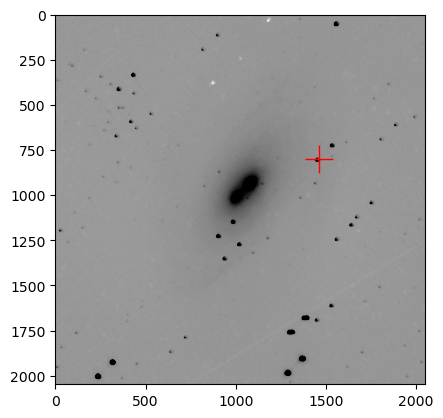

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Showing 24mar25-005r.fit
[ -0.8 -11. ]


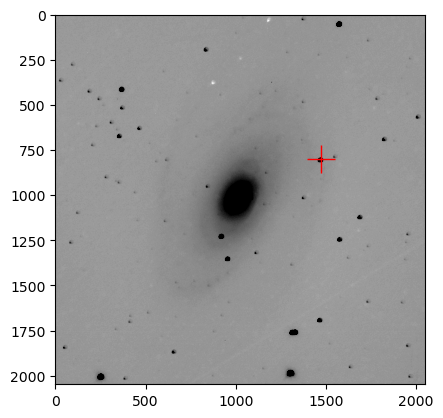

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Showing 24mar25-006r.fit
[-1.2 -9.8]


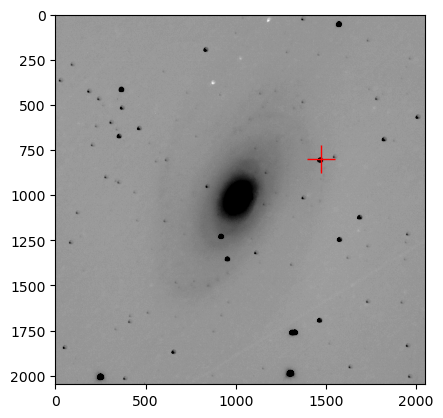

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Showing 24mar25-007r.fit
[0. 0.]


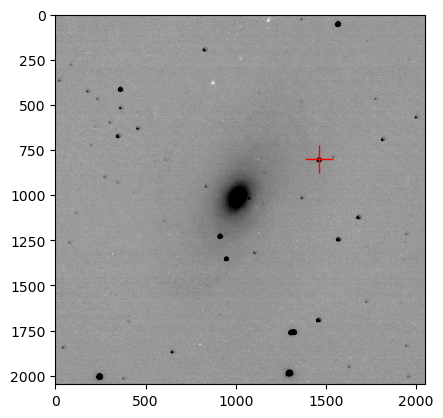

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Showing 24mar25-002i.fit
[ 79.8 -71. ]


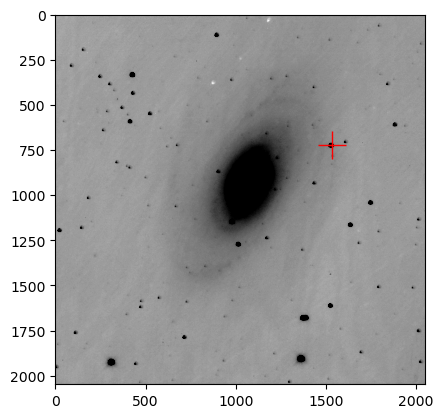

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Showing 24mar25-003i.fit
[ 80.2 -68.4]


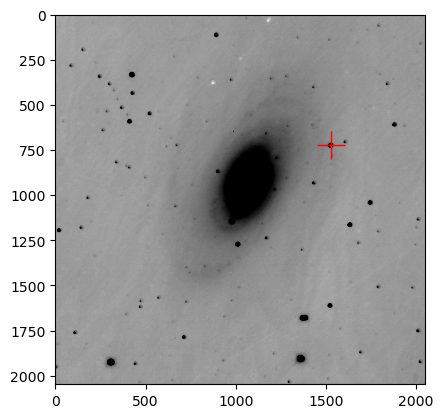

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Showing 24mar25-004i.fit
[ 82. -66.]


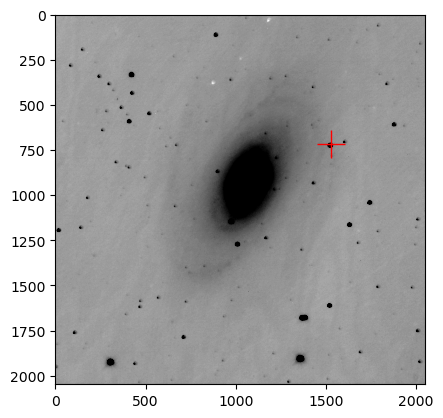

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Showing 24mar25-005b.fit
[0. 0.]


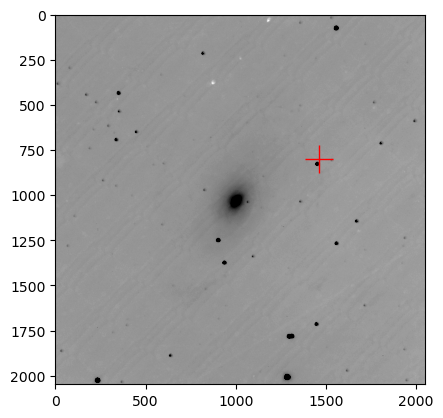

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Showing 24mar25-006b.fit
[-12.   0.]


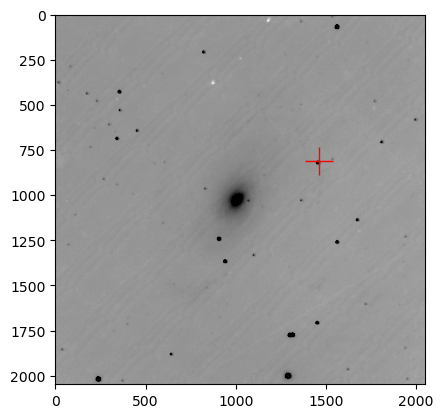

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Showing 24mar25-007b.fit
[-10.6   2.2]


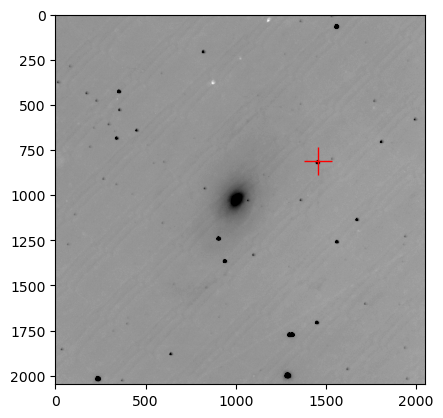

In [14]:
#Read in all files in *reduced* image directory
#You will need to modify the filenames to include all of your color images
science_ifc=ccdp.ImageFileCollection(reduced_dir,filenames=['24mar25-001v.fit','24mar25-002v.fit','24mar25-003v.fit',
                                                            '24mar25-005r.fit','24mar25-006r.fit','24mar25-007r.fit',
                                                            '24mar25-002i.fit','24mar25-003i.fit','24mar25-004i.fit',
                                                            '24mar25-005b.fit','24mar25-006b.fit','24mar25-007b.fit'])
science_files = science_ifc.files_filtered()
output_file='image_shifts.p'

show_image_shifts(science_files, reduced_dir, ref_pos=np.array([1460,800])) 

Write a function to shift and average a set of images. Outputs an array.

In [15]:
def shift_average(unshifted_images,reduced_dir, image_shift_file):
#Read in image shifts
    image_shifts=pickle.load( open( reduced_dir+image_shift_file, "rb" ) )

#Loop through all images and create shifted data
    shifted_data=[]
    for myimage in unshifted_images:
        hdul = fits.open(reduced_dir+myimage)
        data = hdul[0].data
        shifted_data.append(interp.shift(data,image_shifts[myimage]))
## array of aligned arrays: 
    image_cube  = np.stack(shifted_data,axis=0)

## average combined final image: 
    image_stacked = np.average(image_cube, axis=0)

    return image_stacked

Use the function to make stacked versions of each color of image.  I've done v.  You'll need to modify and uncomment the other color codes

In [17]:
image_shift_file='image_shifts.p'
science_ifc=ccdp.ImageFileCollection(reduced_dir,filenames=['24mar25-001v.fit','24mar25-002v.fit','24mar25-003v.fit'])
science_files = science_ifc.files_filtered(exptime=60.0)
stacked_image_v=shift_average(science_files,reduced_dir, image_shift_file) #average images

#Modify the code below to make shifted averaged images in each color

science_ifc=ccdp.ImageFileCollection(reduced_dir,filenames=['24mar25-005r.fit','24mar25-006r.fit','24mar25-007r.fit'])
science_files = science_ifc.files_filtered()
stacked_image_b=shift_average(science_files,reduced_dir, image_shift_file)

science_ifc=ccdp.ImageFileCollection(reduced_dir,filenames=['24mar25-002i.fit','24mar25-003i.fit','24mar25-004i.fit'])
science_files = science_ifc.files_filtered()
stacked_image_r=shift_average(science_files,reduced_dir, image_shift_file)

science_ifc=ccdp.ImageFileCollection(reduced_dir,filenames=['24mar25-005b.fit','24mar25-006b.fit','24mar25-007b.fit'])
science_files = science_ifc.files_filtered()
stacked_image_i=shift_average(science_files,reduced_dir, image_shift_file)

Plot the result to make sure it looks okay.  

I've only plotted v.  You'll need to modify and comment out the other colors

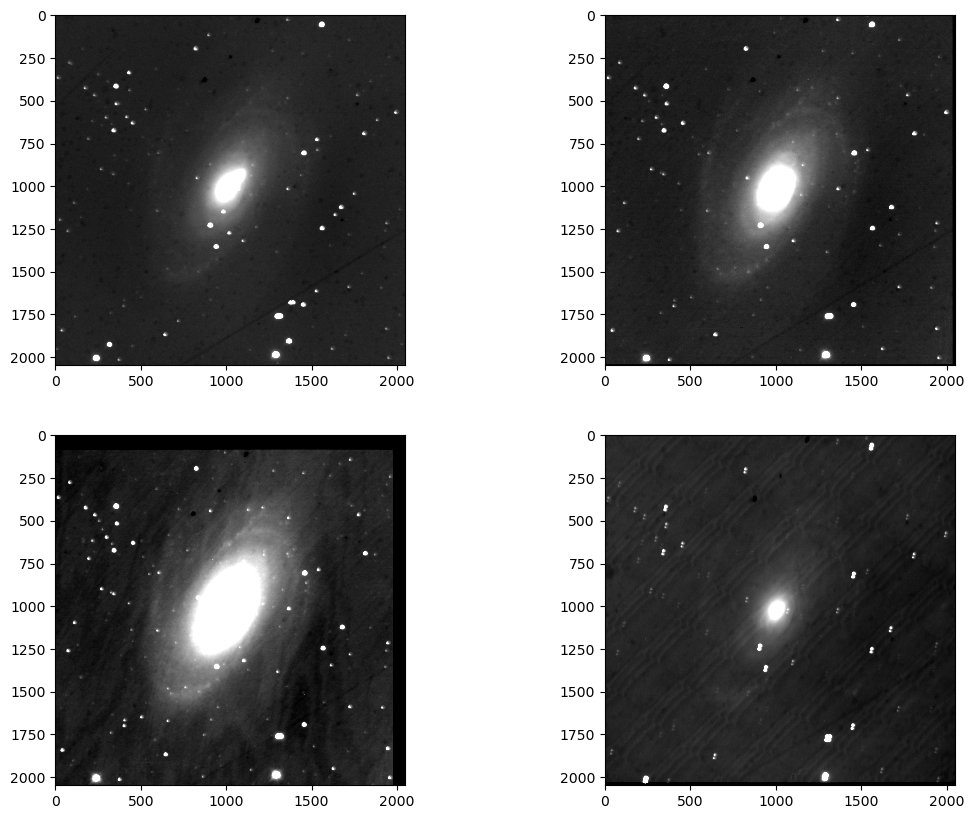

In [20]:
fig=plt.figure(figsize=(13,10))
#Plot image
ax1=fig.add_subplot(221)
ax1.imshow(stacked_image_v, cmap='gray',vmin=np.median(stacked_image_v)*0.95, vmax=np.median(stacked_image_v)*1.3)

#Comment out the lines below to look at your other color images
ax2=fig.add_subplot(222)
ax2.imshow(stacked_image_b, cmap='gray',vmin=np.median(stacked_image_b)*0.95, vmax=np.median(stacked_image_b)*1.3)

ax3=fig.add_subplot(223)
ax3.imshow(stacked_image_r, cmap='gray',vmin=np.median(stacked_image_r)*0.95, vmax=np.median(stacked_image_r)*1.3)

ax4=fig.add_subplot(224)
ax4.imshow(stacked_image_i, cmap='gray',vmin=np.median(stacked_image_i)*0.95, vmax=np.median(stacked_image_i)*1.3)

Now, I'll 'stretch' each image, and combine them into an RGB image.

Here is where you can be an artist, but choosing different color images to display, and by playing with the stretch.

For more info, see: https://docs.astropy.org/en/stable/visualization/normalization.html

In [89]:
stretch = ZScaleInterval()
image_r=stretch(stacked_image_r)
image_g=stretch(stacked_image_v)
image_b=stretch(stacked_image_b)

color_image=np.zeros([2048,2048,3])
color_image[:,:,2]=image_r
color_image[:,:,0]=image_g
color_image[:,:,1]=image_b

## Now plot your final color image!

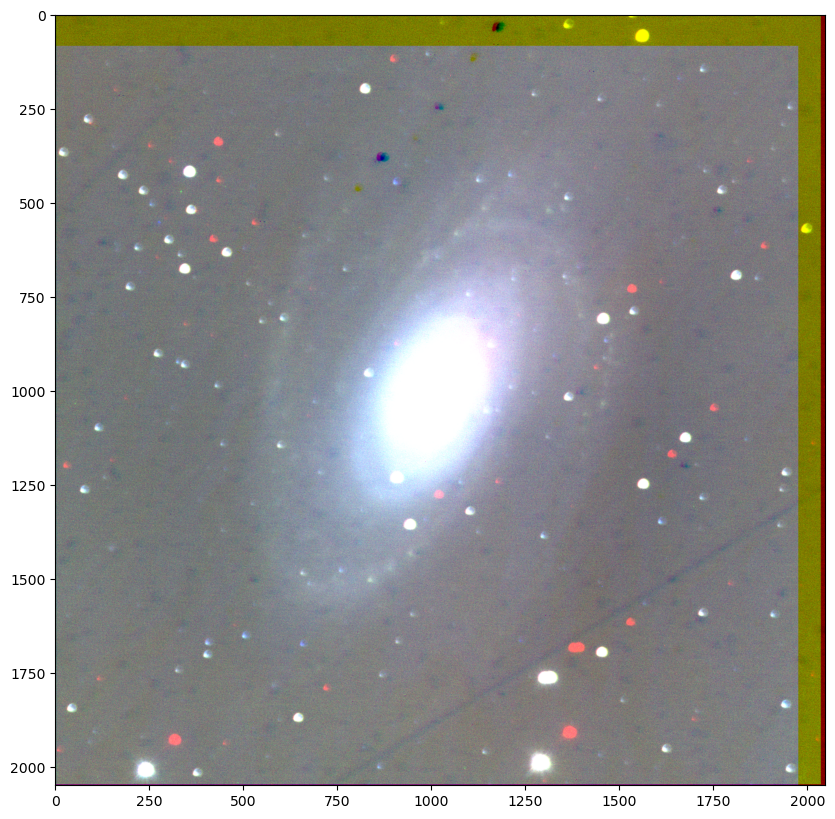

In [94]:
fig=plt.figure(figsize=(10,10))
#Plot image
ax1=fig.add_subplot(111)
ax1.imshow(color_image)

plt.savefig('final_mci_image')